# 先行研究パラメータ検証

このnotebookは先行研究で見つかったパラメータのみを用いて広帯域化性能を確認するものです。

In [25]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from syuron import shg, mgoslt, pp
import japanize_matplotlib
import numpy as np
import jax

jax.config.update("jax_enable_x64", True)  # 高精度計算を有効化

# =============================================================================
# 条件設定（先頭でまとめて変更可能）
# =============================================================================

# 基本パラメータ
PERIOD = 7.2  # mm (1030nm位相整合波長)
TOTAL_DOMAINS = int(2000/(7.2/2))  # 約10mmのデバイス長
DEVICE_LENGTH = PERIOD * TOTAL_DOMAINS / 2
KAPPA = 1.031E-05
TEMP = 70.0

# 計算波長範囲（広帯域性能確認用）
WAVELENGTH_RANGE = jnp.linspace(1.025, 1.035, 1000).tolist()  # 1030nm周辺

# 先行研究パラメータ（論文より）
PAPER_ADJUST_WIDTH = PERIOD  # 周期と同じ幅 = 7.2 mm
PAPER_ADJUST_POSITION = int(0.165 * TOTAL_DOMAINS)  # 0.165L の位置

# 帯域幅計算の基準設定
BANDWIDTH_THRESHOLD = 0.99  # 99%基準

print(f"基本設定:")
print(f"  周期: {PERIOD:.1f} mm")
print(f"  総ドメイン数: {TOTAL_DOMAINS}")
print(f"  デバイス長: {DEVICE_LENGTH:.1f} mm")
print(
    f"  計算波長範囲: {min(WAVELENGTH_RANGE):.3f} - {max(WAVELENGTH_RANGE):.3f} μm")
print(f"\n先行研究パラメータ:")
print(f"  調整層幅: {PAPER_ADJUST_WIDTH:.1f} mm (周期×1.0)")
print(f"  調整層位置: {PAPER_ADJUST_POSITION} (0.165L)")
print(f"  帯域幅基準: {BANDWIDTH_THRESHOLD*100:.0f}%")

基本設定:
  周期: 7.2 mm
  総ドメイン数: 555
  デバイス長: 1998.0 mm
  計算波長範囲: 1.025 - 1.035 μm

先行研究パラメータ:
  調整層幅: 7.2 mm (周期×1.0)
  調整層位置: 91 (0.165L)
  帯域幅基準: 99%


In [26]:
def create_paper_pros_structure() -> shg.DomainTensor:
    """
    先行研究のパラメータを用いて2セグメントPROS構造を生成

    Returns:
        DomainTensor (shape: 1, TOTAL_DOMAINS, 2)
    """
    # 基本幅の配列を作成
    base_widths = jnp.full(TOTAL_DOMAINS, PERIOD / 2)

    # 調整層位置で幅を変更
    widths = base_widths.at[PAPER_ADJUST_POSITION].set(PAPER_ADJUST_WIDTH)

    # カッパ値を設定（偶数インデックス: +, 奇数インデックス: -）
    domain_indices = jnp.arange(TOTAL_DOMAINS)
    kappas = jnp.where(domain_indices % 2 == 0, KAPPA, -KAPPA)

    # テンソルを作成（バッチサイズ1）
    tensor = jnp.stack([widths, kappas], axis=-1)[None,
                                                  :]  # (1, TOTAL_DOMAINS, 2)
    return tensor


print("先行研究パラメータ用PROS構造生成関数を定義しました")

先行研究パラメータ用PROS構造生成関数を定義しました


In [27]:
def calculate_bandwidth(efficiency_spectrum: jnp.ndarray, threshold: float = 0.5) -> float:
    """
    効率スペクトラムから帯域幅を計算

    Args:
        efficiency_spectrum: 効率スペクトラム配列
        threshold: 帯域幅計算の閾値（最大値に対する比率）

    Returns:
        帯域幅 (μm)
    """
    max_eff = jnp.max(efficiency_spectrum)
    above_threshold = efficiency_spectrum >= max_eff * threshold

    if jnp.sum(above_threshold) == 0:
        return 0.0

    # 閾値を超える波長範囲を計算
    wavelength_array = jnp.array(WAVELENGTH_RANGE)
    valid_wavelengths = wavelength_array[above_threshold]

    return jnp.max(valid_wavelengths) - jnp.min(valid_wavelengths)


def calculate_flatness_score(efficiency_spectrum: jnp.ndarray, threshold: float = 0.99) -> float:
    """
    効率スペクトラムの平坦性スコアを計算

    Args:
        efficiency_spectrum: 効率スペクトラム配列
        threshold: 閾値（最大値に対する比率）

    Returns:
        平坦性スコア (0-1, 1が最も平坦)
    """
    max_eff = jnp.max(efficiency_spectrum)
    above_threshold = efficiency_spectrum >= max_eff * threshold

    if jnp.sum(above_threshold) == 0:
        return 0.0

    # 閾値を超える点での平均と分散
    valid_values = efficiency_spectrum[above_threshold]
    mean_val = jnp.mean(valid_values)
    std_val = jnp.std(valid_values)

    # 正規化分散の逆数（平坦性スコア）
    normalized_std = std_val / (mean_val + 1e-10)
    flatness_score = 1.0 / (1.0 + normalized_std)

    return flatness_score


print("評価関数を定義しました")

評価関数を定義しました


In [28]:
# 先行研究パラメータでPROS構造を生成
print("先行研究パラメータでPROS構造を生成中...")
paper_pros_tensor = create_paper_pros_structure()

print(f"生成されたテンソル形状: {paper_pros_tensor.shape}")
print(
    f"調整層位置 {PAPER_ADJUST_POSITION} の幅: {paper_pros_tensor[0, PAPER_ADJUST_POSITION, 0]:.3f} mm")
print(f"基本層の幅（例：位置0）: {paper_pros_tensor[0, 0, 0]:.3f} mm")

先行研究パラメータでPROS構造を生成中...
生成されたテンソル形状: (1, 555, 2)
調整層位置 91 の幅: 7.200 mm
基本層の幅（例：位置0）: 3.600 mm


In [29]:
# SHG解析を実行
print("先行研究パラメータでSHG解析を実行中...")

shg_params = shg.Params(
    grating_dim=paper_pros_tensor,
    T_dim=[TEMP],
    wavelength_dim=WAVELENGTH_RANGE,
    fund_power_dim=1,
    sh_power_dim=0
)

eff_tensor = shg.analyze(shg_params, mgoslt.use_material, shg.solve_ncme_npda)
power = jnp.abs(eff_tensor[0, 0, :, 0, 0])**2  # (wavelength_points,)

print(f"SHG解析完了")
print(f"効率スペクトラム形状: {power.shape}")

# 性能評価
max_efficiency = jnp.max(power)
bandwidth = calculate_bandwidth(power, BANDWIDTH_THRESHOLD)
flatness_score = calculate_flatness_score(power, BANDWIDTH_THRESHOLD)

print(f"\n=== 先行研究パラメータの性能評価 ===")
print(f"最大効率: {max_efficiency:.8f}")
print(f"帯域幅（{BANDWIDTH_THRESHOLD*100:.0f}%基準）: {bandwidth:.6f} μm ({bandwidth*1000:.1f} nm)")
print(f"平坦性スコア: {flatness_score:.6f}")
print(f"\nパラメータ:")
print(
    f"  調整層幅: {PAPER_ADJUST_WIDTH:.1f} mm (周期×{PAPER_ADJUST_WIDTH/PERIOD:.1f})")
print(
    f"  調整層位置: {PAPER_ADJUST_POSITION} ({PAPER_ADJUST_POSITION/TOTAL_DOMAINS:.3f}L)")

先行研究パラメータでSHG解析を実行中...
SHG解析完了
効率スペクトラム形状: (1000,)

=== 先行研究パラメータの性能評価 ===
最大効率: 0.00007765
帯域幅（99%基準）: 0.000721 μm (0.7 nm)
平坦性スコア: 0.997921

パラメータ:
  調整層幅: 7.2 mm (周期×1.0)
  調整層位置: 91 (0.164L)


/tmp/ipykernel_48052/3859368707.py:75: UserWarning: Glyph 20808 (\N{CJK UNIFIED IDEOGRAPH-5148}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_48052/3859368707.py:75: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_48052/3859368707.py:75: UserWarning: Glyph 30740 (\N{CJK UNIFIED IDEOGRAPH-7814}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_48052/3859368707.py:75: UserWarning: Glyph 31350 (\N{CJK UNIFIED IDEOGRAPH-7A76}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_48052/3859368707.py:75: UserWarning: Glyph 12497 (\N{KATAKANA LETTER PA}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_48052/3859368707.py:75: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_48052/3859368707.py:75: UserWarning: Glyph 12513 (\N{KATAKA

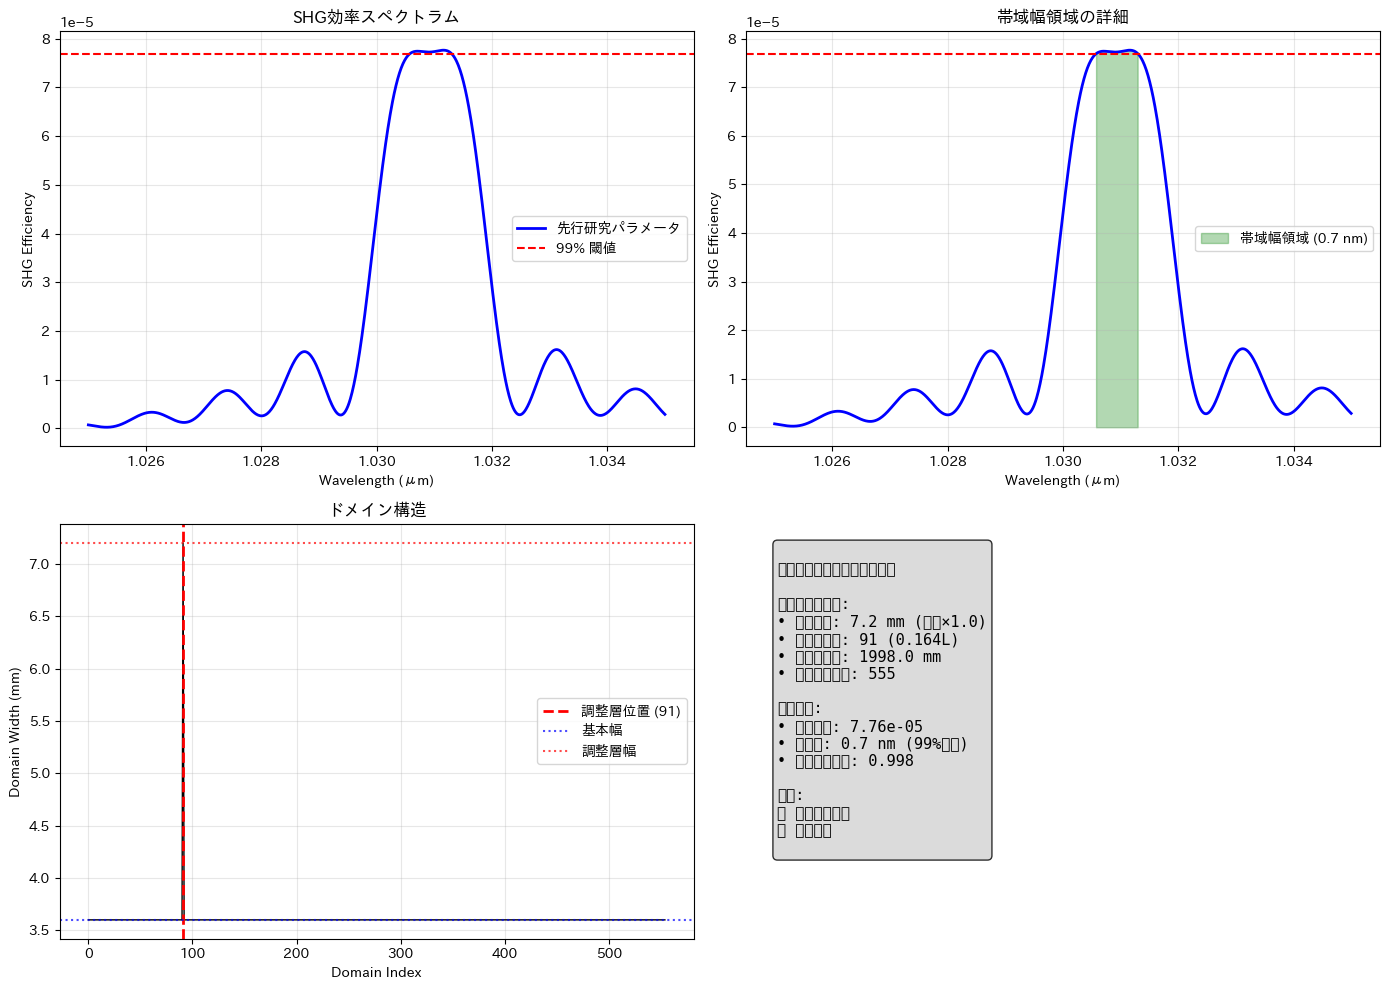


先行研究パラメータによる広帯域化性能を確認しました。
帯域幅 0.7 nm は1030nm周辺での広帯域化として 有効 です。


In [30]:
# 結果の可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 効率スペクトラム
ax1 = axes[0, 0]
ax1.plot(WAVELENGTH_RANGE, power, 'b-', linewidth=2, label='先行研究パラメータ')
ax1.axhline(y=max_efficiency * BANDWIDTH_THRESHOLD, color='r', linestyle='--',
            label=f'{BANDWIDTH_THRESHOLD*100:.0f}% 閾値')
ax1.set_xlabel('Wavelength (μm)')
ax1.set_ylabel('SHG Efficiency')
ax1.set_title('SHG効率スペクトラム')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 帯域幅領域のズーム
ax2 = axes[0, 1]
# 閾値を超える領域を強調
above_threshold = power >= max_efficiency * BANDWIDTH_THRESHOLD
wavelength_array = np.array(WAVELENGTH_RANGE)

ax2.plot(WAVELENGTH_RANGE, power, 'b-', linewidth=2)
ax2.fill_between(wavelength_array, 0, power, where=above_threshold,
                 alpha=0.3, color='green', label=f'帯域幅領域 ({bandwidth*1000:.1f} nm)')
ax2.axhline(y=max_efficiency * BANDWIDTH_THRESHOLD, color='r', linestyle='--')
ax2.set_xlabel('Wavelength (μm)')
ax2.set_ylabel('SHG Efficiency')
ax2.set_title('帯域幅領域の詳細')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. ドメイン構造
ax3 = axes[1, 0]
domain_widths = paper_pros_tensor[0, :, 0]
domain_indices = range(TOTAL_DOMAINS)

ax3.plot(domain_indices, domain_widths, 'k-', linewidth=1)
ax3.axvline(x=PAPER_ADJUST_POSITION, color='red', linestyle='--', linewidth=2,
            label=f'調整層位置 ({PAPER_ADJUST_POSITION})')
ax3.axhline(y=PERIOD/2, color='blue', linestyle=':', alpha=0.7, label='基本幅')
ax3.axhline(y=PAPER_ADJUST_WIDTH, color='red',
            linestyle=':', alpha=0.7, label='調整層幅')
ax3.set_xlabel('Domain Index')
ax3.set_ylabel('Domain Width (mm)')
ax3.set_title('ドメイン構造')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 性能サマリー
ax4 = axes[1, 1]
ax4.axis('off')

summary_text = f"""
先行研究パラメータ性能評価

設定パラメータ:
• 調整層幅: {PAPER_ADJUST_WIDTH:.1f} mm (周期×{PAPER_ADJUST_WIDTH/PERIOD:.1f})
• 調整層位置: {PAPER_ADJUST_POSITION} ({PAPER_ADJUST_POSITION/TOTAL_DOMAINS:.3f}L)
• デバイス長: {DEVICE_LENGTH:.1f} mm
• 総ドメイン数: {TOTAL_DOMAINS}

性能結果:
• 最大効率: {max_efficiency:.2e}
• 帯域幅: {bandwidth*1000:.1f} nm ({BANDWIDTH_THRESHOLD*100:.0f}%基準)
• 平坦性スコア: {flatness_score:.3f}

評価:
{'✅ 広帯域化達成' if bandwidth*1000 > 0.5 else '❌ 帯域幅不足'}
{'✅ 高平坦性' if flatness_score > 0.9 else '⚠️ 平坦性改善余地'}
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n先行研究パラメータによる広帯域化性能を確認しました。")
print(f"帯域幅 {bandwidth*1000:.1f} nm は1030nm周辺での広帯域化として {'有効' if bandwidth*1000 > 0.5 else '不十分'} です。")